# Natural Language Processing - Project 2

* Name: Patrick Murphy
* Under the guidance of professor Daniel Rodriguez

In [ ]:
# import dill dill.dump_session('notebook_env.db')
# import dill dill.load_session('notebook_env.db')

## 1. Downloading Necessary Documents

We will analyse the hawkishness and dovishness of the FOMC Press Conference Transcripts and the Press Releases.

### 1.1 Downloading the FOMC Press Conference transcripts

We download the transcripts for the FOMC Press Conferences in PDF format. These range from the year 2018 to 2022. There are in total eight press conferences per year. In the year 2018 there were only four meetings. Therefore we work with 36 files.

In [33]:
import os
import requests

# creating directory for the transcripts files
if not os.path.exists('transcripts'):
    os.makedirs('transcripts')    

# links where the files are hosted
links = open(os.path.join('documents', 'transcripts_links.txt'), 'r').read().splitlines()

# downloading them in the newly created directory
for url in links:
    filename = url.split('/')[-1]
    path = os.path.join('transcripts', filename)
    
    # checking if file already exists before downloading again
    if not os.path.isfile(path):
        response = requests.get(url)
        if response.status_code == 200:
            with open(path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Failed to download file: {url}")

### 1.2 Downloading the Press Release Statements

In [34]:
import requests
from bs4 import BeautifulSoup

def get_statements_links():
    url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all <a> tags with href attributes that match the specified pattern
        links = soup.find_all('a', href=lambda href: href and '/newsevents/pressreleases/monetary' in href, text="HTML")

        # Create a list to store the hyperlinks
        hyperlinks = []

        # Iterate through the matching links, extract the href attribute, and store it in the list
        for link in links:
            href = link.get('href')
            hyperlinks.append(href)
            
        return hyperlinks

    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

In [35]:
import requests
from bs4 import BeautifulSoup

def extract_article_text(url):
    # url = 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230322a.htm' #test url

    response = requests.get(url)
    response.encoding = 'utf-8'

    paragraph_texts = []

    if response.status_code == 200:
        # Parse the HTML content of the page using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the <div> with id="article"
        article_div = soup.find('div', id='article')

        if article_div:
            # Find the <div> with class "col-xs-12 col-sm-8 col-md-8" within the article_div
            content_div = article_div.find('div', class_='col-xs-12 col-sm-8 col-md-8')

            if content_div:
                # Find all <p> tags within the content_div
                paragraphs = content_div.find_all('p')

                # Extract and append the text within each <p> tag to the list
                for paragraph in paragraphs:
                    paragraph_text = paragraph.get_text()
                    paragraph_texts.append(paragraph_text)
            else:
                print("No 'col-xs-12 col-sm-8 col-md-8' div found within 'article'.")
        else:
            print("No 'article' div found on the page.")
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

    # Now, you have a list of paragraph_text elements in the 'paragraph_texts' list
    return paragraph_texts

In [36]:
import re

def process_article(article_text):
    clean_text = []
    
    for extracted_text in article_text:
        
        phrases = ["Voting for the","For media inquiries"]
        for phrase in phrases:
            if phrase in extracted_text:
                return clean_text
        
        extracted_text = extracted_text.replace('U.S.', 'US')
        extracted_text = extracted_text.split('\n')
        
        _ = []
        for string in extracted_text:
            _ += string.split('.')
        extracted_text = _
        
        extracted_text = [string for string in extracted_text if string.strip() != '']

        clean_text += extracted_text
    
    return clean_text

In [37]:
import re

def get_date(link):
    # Extract the date using regular expressions
    match = re.search(r'(\d{4})(\d{2})(\d{2})', link)

    if match:
        year, month, day = match.groups()
        formatted_date = f'{year}-{month}-{day}'
        
        return formatted_date
        
    else:
        print("Date not found in the link.")

In [38]:
press_releases = {}
base_url = 'https://www.federalreserve.gov'
links = get_statements_links()

for link in links:
    date = get_date(link)

    if date >= '2023-01-01':
        continue

    text = extract_article_text(base_url+link)
    text = process_article(text)
    
    press_releases[date] = text

## 2. Extracting the text from the PDF files

In [22]:
# pip install pypdf
import os
from pypdf import PdfReader
import nltk
from nltk.tokenize import sent_tokenize

#nltk.download('punkt')

def process_transcript(reader):
    content = []
    
    for i in range(len(reader.pages)):
        page = reader.pages[i] #opens a page
        text = page.extract_text() #extracts text
        
        split_string = text.split('\n', 3)  # Split the string at each newline character
        if len(split_string) >= 3:
            text = '\n'.join(split_string[3:])  # Join the parts from the third newline
        
        #removes multiple spaces into single spaces
        text = ' '.join(text.split())
        
        text = sent_tokenize(text)
        
        content += text # gathers all content into a single list

    return content

if __name__ == "__main__":
    
    #creating new folder for clean transcripts
    if not os.path.exists('clean_transcripts'):
        os.makedirs('clean_transcripts') 
    
    #loop through all transcripts
    for file_name in os.listdir('transcripts'):
        
        new_file_name = file_name[:-3] + 'txt'  # name for clean transcript
        new_path = os.path.join('clean_transcripts', new_file_name) # path for clean transcript
        
        #check if files already exists
        if not os.path.isfile(new_path):     
            #read and process transcript
            path = os.path.join('transcripts', file_name)
            reader = PdfReader(path)
            text = process_transcript(reader)

            with open(new_path, 'w', encoding = 'utf-8') as file:
                for string in text:
                    file.write(string + '\n')

In [40]:
press_releases

{'2022-01-26': ['Indicators of economic activity and employment have continued to strengthen',
  ' The sectors most adversely affected by the pandemic have improved in recent months but are being affected by the recent sharp rise in COVID-19 cases',
  ' Job gains have been solid in recent months, and the unemployment rate has declined substantially',
  ' Supply and demand imbalances related to the pandemic and the reopening of the economy have continued to contribute to elevated levels of inflation',
  ' Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to US households and businesses',
  'The path of the economy continues to depend on the course of the virus',
  ' Progress on vaccinations and an easing of supply constraints are expected to support continued gains in economic activity and employment as well as a reduction in inflation',
  ' Risks to the economic outlook remain, including from new variants

In [23]:
file = open('clean_transcripts/FOMCpresconf20180321.txt', 'r', encoding = 'utf-8').read().splitlines()
print(file)

['March 21, 2018 CHAIRMAN POWELL.', 'Good afternoon.', 'I have a brief statement, and then I’ll be happy to respond to your questions.', 'The job market remains strong, the economy continues to expand, and inflation appears to be moving toward the FOMC’s 2 percent longer-run goal.', 'As you already know, we decided today to raise the target rate for the federal funds rate by ¼ percentage point, bringing it to 1½ to 1¾ percent.1 This decision marks another step in the ongoing process of gradually scaling back monetary policy accommodation—a process that has been under way for several years now.', 'Job gains averaged 240,000 per month over the past three months, well above the pace needed in the longer run to absorb new entrants into the labor force.', 'The unemployment rate remained low in February at 4.1 percent, while the labor force participation rate moved higher.', 'Over the past four years, the participation rate has remained roughly unchanged.', 'That’s a sign of improvement, giv

## 3. Analyzing the text

* Label_2: neutral text, it will be assigned a score of 0.
* Label_1: hawkish text, it will be assigned a score of 1.
* Label_0: dovish text, it will be assigned a score of -1.

In [25]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)

model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)

config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

In [29]:
nlp = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, framework="pt")

In [60]:
import pandas as pd
from datetime import datetime

transcripts_scores = {}

for file_name in os.listdir('clean_transcripts'):
    text = open(os.path.join('clean_transcripts', file_name), 'r', encoding = 'utf-8').read().splitlines()
    results = nlp(text)
    
    df = pd.DataFrame(results)
    df['sentiment'] = df['label'].map({'LABEL_2': 0, 'LABEL_1': 1, 'LABEL_0': -1})

    date = file_name.split('.')[0][-8:]
    new_date = datetime.strptime(date, '%Y%m%d').strftime('%Y-%m-%d')
    
    transcripts_scores[new_date] = df['sentiment'].sum()
    
print(transcripts_scores)

{'2018-03-21': 18, '2018-06-13': 21, '2018-09-26': 20, '2018-12-19': 3, '2019-01-30': 4, '2019-03-20': -22, '2019-05-01': 2, '2019-06-19': -16, '2019-07-31': -31, '2019-09-18': -25, '2019-10-30': -24, '2019-12-11': -10, '2020-01-29': -11, '2020-03-15': -41, '2020-04-29': -65, '2020-06-10': -74, '2020-07-29': -70, '2020-09-16': -69, '2020-11-05': -63, '2020-12-16': -48, '2021-01-27': -38, '2021-03-17': -21, '2021-04-28': -10, '2021-06-16': 33, '2021-07-28': 21, '2021-09-22': 8, '2021-11-03': -15, '2021-12-15': 33, '2022-01-26': 49, '2022-03-16': 85, '2022-05-04': 68, '2022-06-15': 80, '2022-07-27': 39, '2022-09-21': 63, '2022-11-02': 53, '2022-12-14': 34, '2023-02-01': 49}


In [61]:
import pandas as pd
press_scores = {}

for date in press_releases:
    text = press_releases[date]
    results = nlp(text)
    
    df = pd.DataFrame(results)
    df['sentiment'] = df['label'].map({'LABEL_2': 0, 'LABEL_1': 1, 'LABEL_0': -1})
    
    press_scores[date] = df['sentiment'].sum()

print(press_scores)

{'2022-01-26': 1, '2022-03-16': 6, '2022-05-04': 5, '2022-06-15': 5, '2022-07-27': 5, '2022-09-21': 5, '2022-11-02': 6, '2022-12-14': 6, '2021-01-27': -9, '2021-03-17': -8, '2021-04-28': -5, '2021-06-16': -4, '2021-07-28': -4, '2021-09-22': -3, '2021-11-03': -1, '2021-12-15': 0, '2020-01-29': -1, '2020-03-03': -2, '2020-03-15': -2, '2020-03-23': -4, '2020-04-29': -6, '2020-06-10': -7, '2020-07-29': -7, '2020-09-16': -7, '2020-11-05': -7, '2020-12-16': -8, '2019-01-30': 1, '2019-03-20': 0, '2019-05-01': 1, '2019-06-19': -1, '2019-07-31': -1, '2019-09-18': -2, '2019-10-11': 2, '2019-10-30': 0, '2019-12-11': 1, '2018-01-31': 1, '2018-03-21': 0, '2018-05-02': 1, '2018-06-13': 3, '2018-08-01': 2, '2018-09-26': 4, '2018-11-08': 2, '2018-12-19': 3}


In [86]:
import pandas as pd
_ = {
    'date': list(transcripts_scores.keys()),
    'transcript_score': list(transcripts_scores.values())
}

df1 = pd.DataFrame(_).set_index('date').sort_index()

_ = {
    'date': list(press_scores.keys()),
    'press_score': list(press_scores.values())
}

df2 = pd.DataFrame(_).set_index('date').sort_index()

In [89]:
scores = df1.join(df2)

scores['total_score'] = 0.1*scores['transcript_score'] + 0.9*scores['press_score']
scores = scores.dropna()
scores

,transcript_score,press_score,total_score
date,,,
2018-03-21,18,0.0,1.8
2018-06-13,21,3.0,4.8
2018-09-26,20,4.0,5.6
2018-12-19,3,3.0,3.0
2019-01-30,4,1.0,1.3
2019-03-20,-22,0.0,-2.2
2019-05-01,2,1.0,1.1
2019-06-19,-16,-1.0,-2.5
2019-07-31,-31,-1.0,-4.0


<AxesSubplot:xlabel='date'>

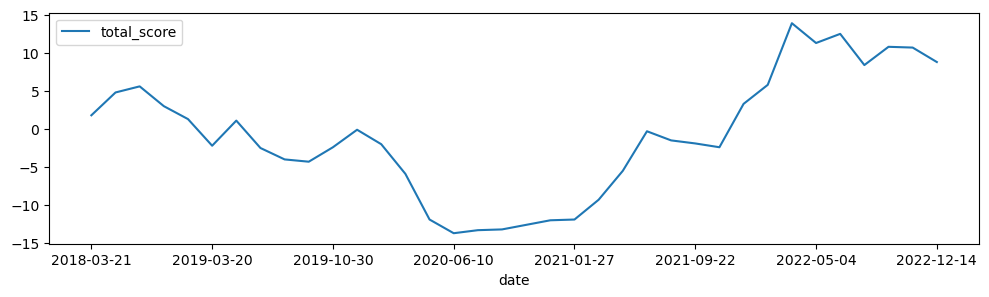

In [92]:
scores.plot(y = 'total_score', figsize = (12,3))

## 4. Getting the market data

<AxesSubplot:xlabel='date'>

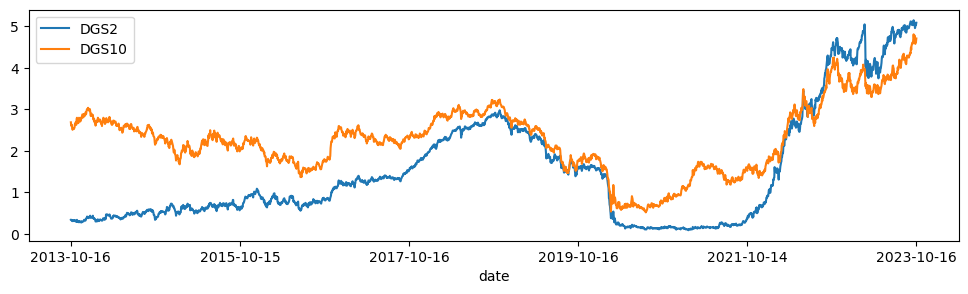

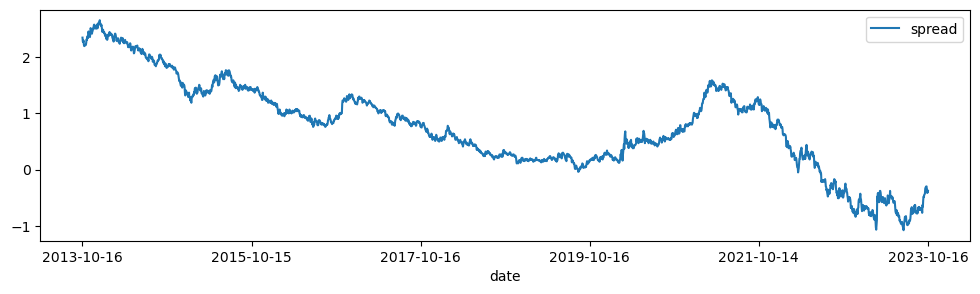

In [106]:
import pandas as pd
dgs2 = pd.read_csv('data/DGS2.csv').set_index('DATE').rename_axis('date')
dgs2['DGS2'] = pd.to_numeric(dgs2['DGS2'], errors = 'coerce')
dgs2 = dgs2.dropna()

dgs10 = pd.read_csv('data/DGS10.csv').set_index('DATE').rename_axis('date')
dgs10['DGS10'] = pd.to_numeric(dgs10['DGS10'], errors = 'coerce')
dgs10 = dgs10.dropna()

yields = dgs2.join(dgs10)
yields.plot(y = ['DGS2', 'DGS10'], figsize = (12,3))

yields['spread'] =  yields['DGS10'] - yields['DGS2']
yields.plot(y = 'spread', figsize = (12,3))

### 4.1 Calculating the %change in the spread, before and after the press release and conference

In [128]:
from datetime import datetime, timedelta

def find_dates(date_list, check_list):
    # Convert check_list to a set for faster lookup
    check_set = set(datetime.strptime(date, '%Y-%m-%d').date() for date in check_list)

    next_dates = []
    prev_dates = []

    for date_str in date_list:
        date = datetime.strptime(date_str, '%Y-%m-%d').date()

        next_date = date
        while next_date not in check_set:
            next_date += timedelta(days=1)
        next_dates.append(next_date.strftime('%Y-%m-%d'))

        # Find the previous date
        prev_date = date - timedelta(days=1)
        while prev_date not in check_set:
            prev_date -= timedelta(days=1)
        prev_dates.append(prev_date.strftime('%Y-%m-%d'))

    return next_dates, prev_dates

future, past = find_dates(list(scores.index), list(yields.index))
checking_dates = pd.DataFrame({
    'date': list(scores.index),
    'past': past,
    'future': future
}).set_index('date')

<AxesSubplot:xlabel='date'>

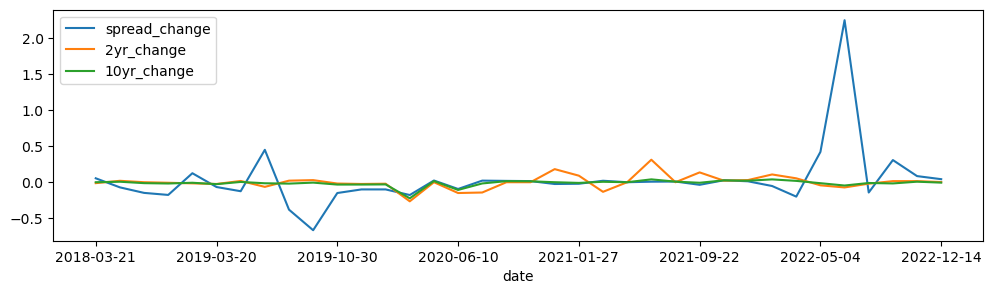

In [145]:
spread_change_dict = {'date': list(scores.index)}
spread_values = []
dgs2_values = []
dgs10_values = []


for date in list(scores.index):
    prev_day = checking_dates.loc[date, 'past']
    next_day = checking_dates.loc[date, 'future']
    
    spread_values.append(yields.loc[next_day, 'spread']/yields.loc[prev_day, 'spread'] - 1)
    dgs2_values.append(yields.loc[next_day, 'DGS2']/yields.loc[prev_day, 'DGS2'] - 1)
    dgs10_values.append(yields.loc[next_day, 'DGS10']/yields.loc[prev_day, 'DGS10'] - 1)

spread_change_dict['spread_change'] = spread_values
spread_change_dict['2yr_change'] = dgs2_values
spread_change_dict['10yr_change'] = dgs10_values

spread_change = pd.DataFrame(spread_change_dict).set_index('date')
spread_change.plot(y = ['spread_change', '2yr_change', '10yr_change'], figsize = (12,3))

## 5 Correlation between scores and yield percent changes

In [151]:
final_df = pd.DataFrame(scores['total_score']).join(spread_change)
final_df

,total_score,spread_change,2yr_change,10yr_change
date,,,,
2018-03-21,1.8,0.054545,-0.012821,0.000000
2018-06-13,4.8,-0.071429,0.019685,0.006757
2018-09-26,5.6,-0.148148,0.000000,-0.012903
2018-12-19,3.0,-0.176471,-0.007547,-0.017730
2019-01-30,1.3,0.125000,-0.015625,-0.007353
2019-03-20,-2.2,-0.066667,-0.024390,-0.026820
2019-05-01,1.1,-0.125000,0.017621,0.003984
2019-06-19,-2.5,0.450000,-0.064516,-0.014563
2019-07-31,-4.0,-0.380952,0.021622,-0.019417


In [155]:
final_df.corr()

,total_score,spread_change,2yr_change,10yr_change
total_score,1.000000,0.317493,0.130166,0.151796
spread_change,0.317493,1.000000,-0.136975,-0.046674
2yr_change,0.130166,-0.136975,1.000000,0.681293
10yr_change,0.151796,-0.046674,0.681293,1.000000


In [156]:
correlations = final_df.corr().iloc[0, 1:]
print(correlations)

spread_change    0.317493
2yr_change       0.130166
10yr_change      0.151796
Name: total_score, dtype: float64
